INFO:root:Загружается файл: /Users/ilyalevshenkov/_GB/GB_Diplom/Sale/Москва_sale_filtered_data.csv
INFO:root:Найденные колонки в данных: ['author', 'author_type', 'url', 'location', 'deal_type', 'accommodation_type', 'floor', 'floors_count', 'rooms_count', 'total_meters', 'price_per_month', 'commissions', 'price', 'district', 'street', 'house_number', 'underground', 'residential_complex']
INFO:root:Форма X после предобработки: (130, 109)
INFO:root:Средняя оценка по кросс-валидации: 257637917938659.0
INFO:root:MSE: 231311416664295.66, R²: 0.6984071085070681, MAE: 10268085.572385218


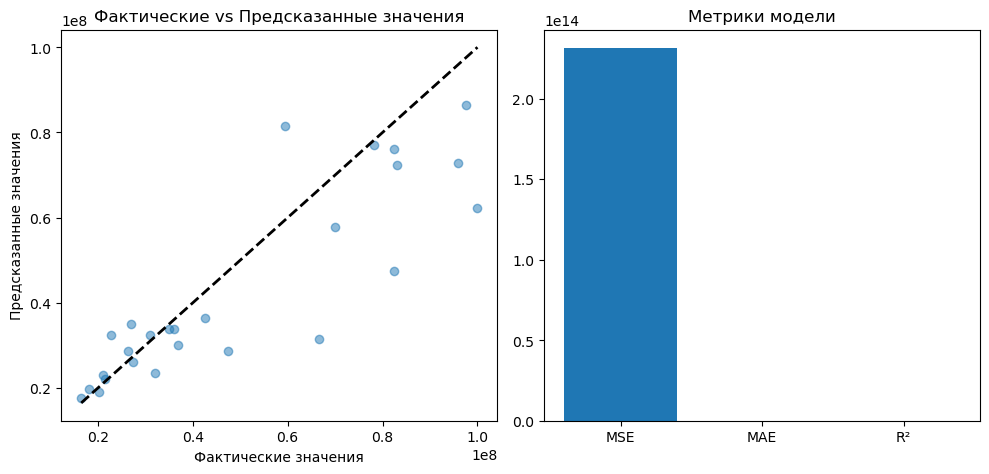

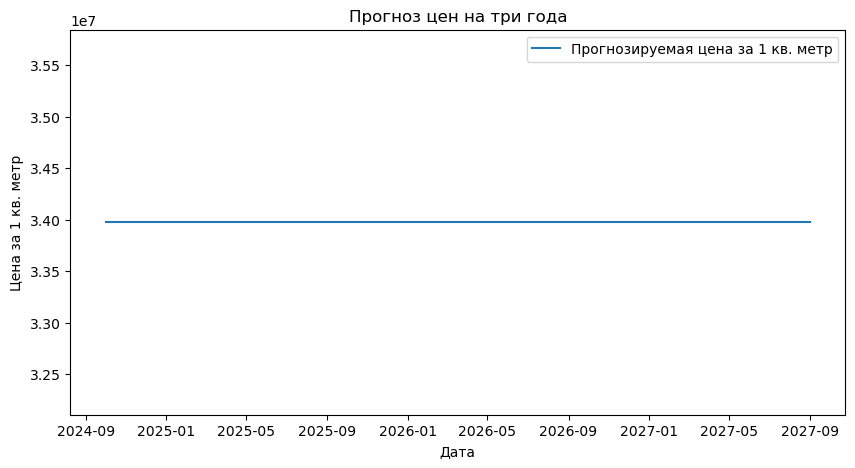

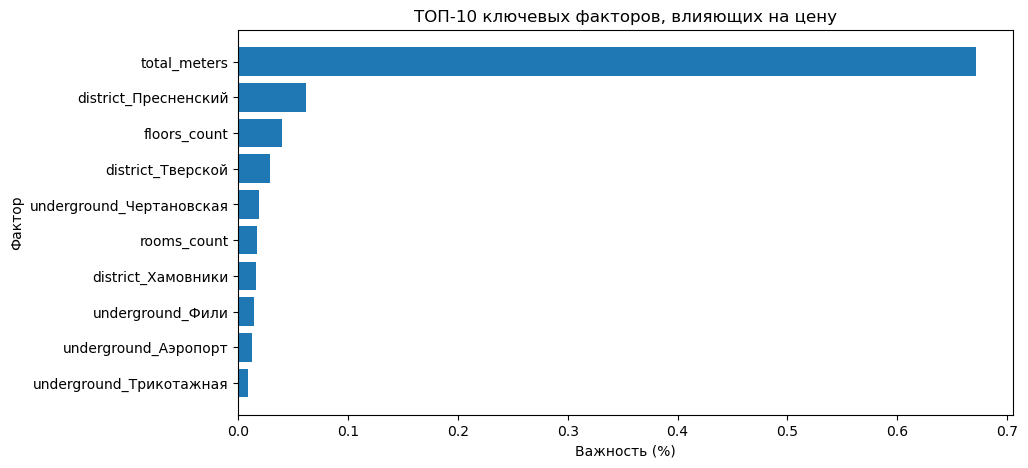

In [9]:
# Модель прогнозирования цен на недвижимость с использованием градиентного бустинга
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
import logging
import matplotlib.pyplot as plt
import datetime

# Настройка логирования
logging.basicConfig(level=logging.INFO)

def load_data():
    """Загрузка данных из последнего CSV файла с 'sale' в папке 'Sale'."""
    csv_files = glob.glob(os.path.join(os.getcwd(), 'Sale', '*sale*.csv'))
    if not csv_files:
        raise FileNotFoundError("В папке 'Sale' нет CSV файлов с 'sale' в названии.")
    
    latest_file = max(csv_files, key=os.path.getctime)
    logging.info(f"Загружается файл: {latest_file}")
    data = pd.read_csv(latest_file, sep=',')  
    return data

def preprocess_data(data):
    """Предобработка данных: выбор признаков, обработка пропусков и выбросов."""
    logging.info(f"Найденные колонки в данных: {data.columns.tolist()}")
    
    required_columns = ['total_meters', 'rooms_count', 'floors_count', 'district', 'underground', 'price']
    missing_columns = [col for col in required_columns if col not in data.columns]
    
    if missing_columns:
        raise KeyError(f"Отсутствуют колонки: {', '.join(missing_columns)}")
    
    # Обработка пропусков
    imputer = SimpleImputer(strategy='median')
    
    features = ['total_meters', 'rooms_count', 'floors_count', 'district', 'underground']
    X = data[features]
    y = data['price']
    
    # Обработка категориальных и числовых признаков
    categorical_features = ['district', 'underground']
    numerical_features = ['total_meters', 'rooms_count', 'floors_count']
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', imputer),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    X = preprocessor.fit_transform(X)
    X = X.toarray()  # Преобразование в плотный формат
    
    logging.info(f"Форма X после предобработки: {X.shape}")
    
    return X, y, preprocessor

def custom_cross_validation(X, y, n_splits=5):
    """Реализация кросс-валидации для модели градиентного бустинга."""
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = GradientBoostingRegressor(random_state=42)
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        
        mse = mean_squared_error(y_val, predictions)
        cv_scores.append(mse)
    
    avg_score = np.mean(cv_scores)
    logging.info(f"Средняя оценка по кросс-валидации: {avg_score}")
    
    return avg_score

def plot_metrics(y_test, predictions):
    """Построение графиков для оценки модели."""
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    metrics = {'MSE': mse, 'MAE': mae, 'R²': r2}
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title('Фактические vs Предсказанные значения')
    
    plt.subplot(1, 2, 2)
    plt.bar(metrics.keys(), metrics.values())
    plt.title('Метрики модели')
    
    plt.tight_layout()
    plt.show()

def plot_price_forecast(model, X, y):
    """Построение прогноза цен на три года."""
    future_dates = pd.date_range(start=datetime.datetime.now(), periods=36, freq='MS')
    future_prices = []

    for i in range(36):
        future_prices.append(model.predict(X.mean(axis=0).reshape(1, -1))[0])
    
    plt.figure(figsize=(10, 5))
    plt.plot(future_dates, future_prices, label='Прогнозируемая цена за 1 кв. метр')
    plt.xlabel('Дата')
    plt.ylabel('Цена за 1 кв. метр')
    plt.title('Прогноз цен на три года')
    plt.legend()
    plt.show()

def plot_feature_importance(model, preprocessor):
    """Построение диаграммы ключевых факторов, влияющих на цену."""
    feature_importances = model.feature_importances_
    feature_names = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out().tolist()
    
    feature_importance_df = pd.DataFrame({
        'Фактор': feature_names,
        'Важность': feature_importances
    }).sort_values(by='Важность', ascending=False)
    
    top_10_features = feature_importance_df.head(10)
    top_10_features.to_csv('top_10_features.csv', index=False)
    
    plt.figure(figsize=(10, 5))
    plt.barh(top_10_features['Фактор'], top_10_features['Важность'])
    plt.xlabel('Важность (%)')
    plt.ylabel('Фактор')
    plt.title('ТОП-10 ключевых факторов, влияющих на цену')
    plt.gca().invert_yaxis()
    plt.show()

def main():
    try:
        # Загрузка данных
        data = load_data()
        
        # Предобработка данных
        X, y, preprocessor = preprocess_data(data)
        
        # Кросс-валидация
        custom_cross_validation(X, y)
        
        # Разделение данных на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Создание модели
        model = GradientBoostingRegressor(random_state=42)
        
        # Обучение модели
        model.fit(X_train, y_train)
        
        # Прогнозирование
        predictions = model.predict(X_test)
        
        # Оценка модели
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        logging.info(f"MSE: {mse}, R²: {r2}, MAE: {mae}")
        
        # Визуализация метрик
        plot_metrics(y_test, predictions)
        
        # Прогноз цен на три года
        plot_price_forecast(model, X, y)
        
        # Диаграмма ключевых факторов
        plot_feature_importance(model, preprocessor)
        
    except Exception as e:
        logging.error(f"Произошла ошибка: {e}")

# Запуск основной функции
if __name__ == "__main__":
    main()
